<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_12_Weights_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Xavier & Kaiming Initializations

In [1]:
# Import the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

import sklearn.metrics as skm

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

In [2]:
# Create a DL Model: We just care for initialization here
class thenet(nn.Module):
    def __init__(self):
        super().__init__()

        # input layer
        self.input = nn.Linear(100, 100)

        # hidden layers
        self.fc1 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)

        # Output Layer
        self.output = nn.Linear(100, 2)

    # Forward pass
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return self.output(x)

In [3]:
# create an instance
net = thenet()
print(net)

thenet(
  (input): Linear(in_features=100, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=2, bias=True)
)


## Kaiming Initialization (Default)

In [6]:
# collect all weights and biases
allweight = np.array([])
allbiases = np.array([])

for p in net.named_parameters():
    if "bias" in p[0]:
        allbiases = np.concatenate((allbiases, p[1].data.numpy().flatten()), axis=0)
    elif "weight" in p[0]:
        allweight = np.concatenate((allweight, p[1].data.numpy().flatten()), axis=0)

# Check the number for each case
print(f"There are {len(allbiases)} bias parameters in the model")
print(f"There are {len(allweight)} weight parameters in the model")
print(f"Biases represent {100*len(allbiases)/len(allweight)}% of total number of weights")

There are 402 bias parameters in the model
There are 40200 weight parameters in the model
Biases represent 1.0% of total number of weights


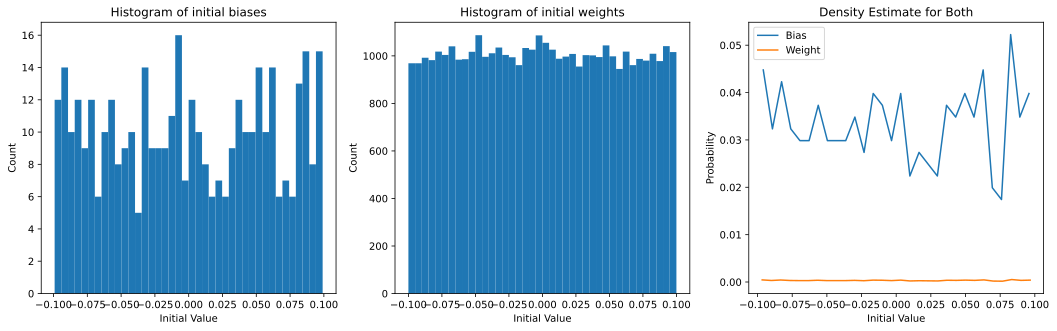

In [8]:
# Create their histograms
fig, ax = plt.subplots(1, 3, figsize=(18,5))

ax[0].hist(allbiases, 40)
ax[0].set_title("Histogram of initial biases")

ax[1].hist(allweight, 40)
ax[1].set_title("Histogram of initial weights")

# Collect histogram data to show as line plots
yB, xB = np.histogram(allbiases, 30)
yW, xW = np.histogram(allweight, 30)

ax[2].plot((xB[1:]+xB[:-1])/2, yB/np.sum(yB), label="Bias")
ax[2].plot((xW[1:]+xW[:-1])/2, yW/np.sum(yW), label="Weight")
ax[2].set_title("Density Estimate for Both")
ax[2].legend()

# Plot adjustments common to all subplots
for i in range(3):
    ax[i].set_xlabel("Initial Value")
    ax[i].set_ylabel("Count")
ax[2].set_ylabel("Probability")

plt.show()

### Layer-Specific Distributions

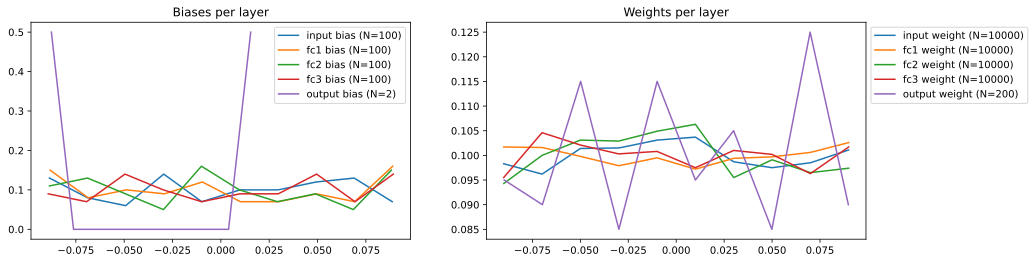

In [9]:
fig,ax = plt.subplots(1,2,figsize=(15,4))

for p in net.named_parameters():
    # get the data and compute their histogram
    thesedata = p[1].data.numpy().flatten()
    y,x = np.histogram(thesedata,10)

    # for the bias
    if 'bias' in p[0]:
        ax[0].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s bias (N=%g)'%(p[0][:-5],len(thesedata)))

    # for the weights
    elif 'weight' in p[0]:
        ax[1].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s weight (N=%g)'%(p[0][:-7],len(thesedata)))

ax[0].set_title('Biases per layer')
ax[0].legend()
ax[1].set_title('Weights per layer')
ax[1].legend(bbox_to_anchor=(1,1),loc='upper left')
plt.show()

In [10]:
# Output has only 2 datapoints, thus it is weird
print(net.output.bias.data)

tensor([ 0.0212, -0.0934])


In [11]:
# Let's see whether the numbers match our predictions from formula
# Empirical bias range
biasrange = [torch.min(net.fc1.bias.data).item(), torch.max(net.fc1.bias.data).item()]
biascount = len(net.fc1.bias.data)

# Theoretical expected value
sigma = np.sqrt(1/biascount)

print(f"Theoretical Sigma: {sigma}")
print(f"Empirical Range: {biasrange}")

Theoretical Sigma: 0.1
Empirical Range: [-0.09816303104162216, 0.09872610867023468]


## Xavier Initialization

In [12]:
# Create a new model instance
net = thenet()

# Change the weights: leave biases default (Kaiming)
# This is not how its done, we are doing it here for illustrative purposes only
for p in net.named_parameters():
    if "weight" in p[0]:
        # The function operates in place (_), no need to reassign
        nn.init.xavier_normal_(p[1].data)

In [13]:
# Use the code from above to visualize
# collect all weights and biases
allweight = np.array([])
allbiases = np.array([])

for p in net.named_parameters():
    if "bias" in p[0]:
        allbiases = np.concatenate((allbiases, p[1].data.numpy().flatten()), axis=0)
    elif "weight" in p[0]:
        allweight = np.concatenate((allweight, p[1].data.numpy().flatten()), axis=0)

# Check the number for each case
print(f"There are {len(allbiases)} bias parameters in the model")
print(f"There are {len(allweight)} weight parameters in the model")
print(f"Biases represent {100*len(allbiases)/len(allweight)}% of total number of weights")

There are 402 bias parameters in the model
There are 40200 weight parameters in the model
Biases represent 1.0% of total number of weights


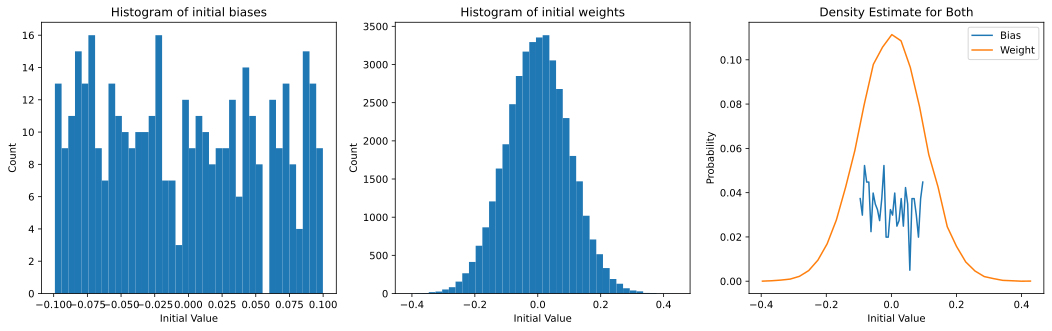

In [16]:
# Create their histograms
fig, ax = plt.subplots(1, 3, figsize=(18,5))

ax[0].hist(allbiases, 40)
ax[0].set_title("Histogram of initial biases")

ax[1].hist(allweight, 40)
ax[1].set_title("Histogram of initial weights")

# Collect histogram data to show as line plots
yB, xB = np.histogram(allbiases, 30)
yW, xW = np.histogram(allweight, 30)

ax[2].plot((xB[1:]+xB[:-1])/2, yB/np.sum(yB), label="Bias")
ax[2].plot((xW[1:]+xW[:-1])/2, yW/np.sum(yW), label="Weight")
ax[2].set_title("Density Estimate for Both")
ax[2].legend()

# Plot adjustments common to all subplots
for i in range(3):
    ax[i].set_xlabel("Initial Value")
    ax[i].set_ylabel("Count")
ax[2].set_ylabel("Probability")

plt.show()

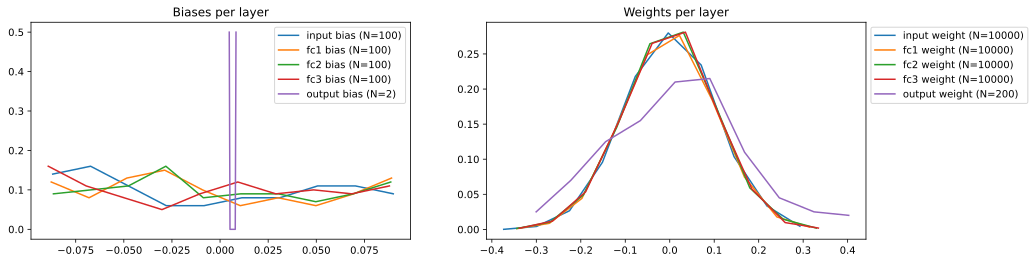

In [17]:
fig,ax = plt.subplots(1,2,figsize=(15,4))

for p in net.named_parameters():
    # get the data and compute their histogram
    thesedata = p[1].data.numpy().flatten()
    y,x = np.histogram(thesedata,10)

    # for the bias
    if 'bias' in p[0]:
        ax[0].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s bias (N=%g)'%(p[0][:-5],len(thesedata)))

    # for the weights
    elif 'weight' in p[0]:
        ax[1].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s weight (N=%g)'%(p[0][:-7],len(thesedata)))

ax[0].set_title('Biases per layer')
ax[0].legend()
ax[1].set_title('Weights per layer')
ax[1].legend(bbox_to_anchor=(1,1),loc='upper left')
plt.show()

In [18]:
# Let's see whether the numbers match our predictions from formula
# Empirical bias range
weightvar = torch.var(net.fc1.weight.data.flatten()).item()
weightcount = len(net.fc1.weight.data)

# Theoretical expected value
sigma = 2/ (weightcount + weightcount)

print(f"Theoretical Sigma: {sigma}")
print(f"Empirical Range: {weightvar}")

Theoretical Sigma: 0.01
Empirical Range: 0.010077204555273056
